The $AR(1)$ process is defined as:
$$X_t = \rho X_{t-1} + \epsilon_t$$
where $\epsilon_t \sim N(0, \sigma^2)$ is white noise and $|\rho| < 1$.

Let us assign the following prior distributions to the parameters:
- $\rho \sim \text{Uniform}(-1, 1)$
- $\sigma \sim \text{Uniform}(0, A)$

We can determine the likelihood by conditioning on $X_0$:
$$
\begin{aligned}
p(\vec x | \rho, \sigma) \quad &\propto \quad (\sigma^2)^{-\frac{T}{2}} \exp\left(-\frac{1}{2\sigma^2} \sum_{t=1}^{T} (x_t - \rho x_{t-1})^2\right) \\
&= \quad (\sigma^2)^{-\frac{T}{2}} \exp\left(-\frac{S(\rho)}{2\sigma^2}\right) \\
\end{aligned}
$$
Where:
$$
\begin{aligned}
S(\rho) &:= \sum_{t=1}^{T} (x_t - \rho x_{t-1})^2 \\
&= \sum_{t=1}^{T} (x_t^2 - 2\rho x_t x_{t-1} + \rho^2 x_{t-1}^2) \\
&= \sum_{t=1}^{T} x_t^2 - 2\rho \sum_{t=1}^{T} x_t x_{t-1} + \rho^2 \sum_{t=1}^{T} x_{t-1}^2 \\
&= Q(\rho^2 - 2\rho \hat \rho)  + const 
 \quad \quad \quad\quad  \text{where} \quad Q := \sum_{t=1}^{T} x_{t-1}^2, \quad \hat \rho := \frac{\sum_{t=1}^{T} x_t x_{t-1}}{Q} \\
&= Q(\rho - \hat \rho)^2 + const
\end{aligned}
$$
## rho conditional
Therefore, we can write the conditional posterior distribution as:
$$
\begin{aligned}
p(\rho|  \sigma , \vec x) \quad &\propto \quad  \sigma^{-T/2} \exp\left(-\frac{Q}{2\sigma^2}(\rho - \hat \rho)^2\right)  \mathbb I_A

\end{aligned}
$$
where we condition on the event $A = \{|\rho| < 1, 0 < \sigma < A\}$.

Ie, we have a normal distribution:
$$
\rho | \sigma, \vec x \sim N\left(\hat \rho, \frac{\sigma^2}{Q}\right)
$$
where we truncate to the interval $(-1, 1)$.

## sigma conditional

Let us first change variables $\lambda := 1/\sigma^2$. Then we have $\left | \frac{d\sigma}{d\lambda} \right | = \frac{1}{2} \lambda^{-3/2}$. The posterior is then:
$$
\begin{aligned}
p(\lambda | \rho, \vec x) \quad &\propto \quad \lambda^{\frac{T}{2} - \frac{3}{2}} \exp\left(-\frac{\lambda}{2} S(\rho)\right) \mathbb I_B\\
\end{aligned}
$$
This is a Gamma distribution:
$$
\lambda | \rho, \vec x \sim \text{Gamma}\left(\frac{T}{2} - \frac{1}{2}, \frac{S(\rho)}{2}\right)
$$
but we must truncate on $\lambda > 1/A^2$.

# Gibbs sampler

In [2]:
import numpy as np
import matplotlib.pyplot as plt

A = 5
T = 64

def truncated_normal(mu, sigma, a=-1, b=1):
    while True:
        sample = np.random.normal(mu, sigma)
        if a <= sample <= b:
            return sample

def truncated_gamma(shape, scale, a=1/A**2):
    while True:
        sample = np.random.gamma(shape, scale)
        if sample >= a:
            return sample

def gibbs(x, n_iter=1000):
    T = len(x) - 1

    Q = np.sum(x[:-1]**2)
    rho_hat = np.sum(x[:-1] * x[1:]) / Q
    const = np.sum(x[1:]**2) - Q * rho_hat**2
    
    S = lambda rho: Q * (rho - rho_hat)**2 + const
               
    samples = np.zeros((n_iter, 2))
    for i in range(n_iter):
        # Sample sigma
        lambda_ = truncated_gamma(T/2, 2/(S(rho_hat) + 1e-6))
        sigma = 1/np.sqrt(lambda_)
        samples[i, 1] = sigma

        # Sample rho
        samples[i, 0] = truncated_normal(rho_hat, sigma/np.sqrt(Q))

    return samples

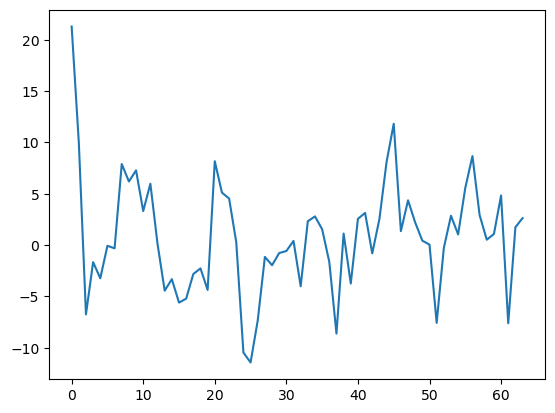

Text(0.5, 1.0, 'Posterior of sigma')

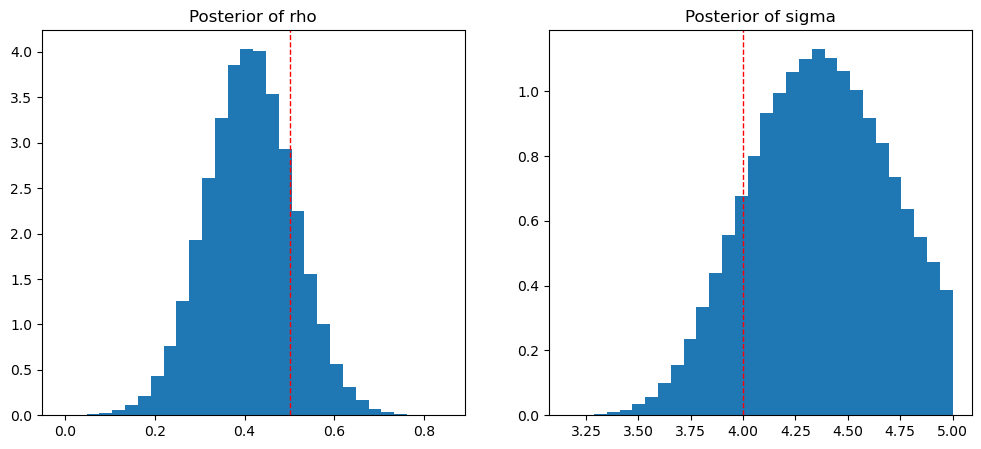

In [3]:
rho = 0.5
sigma = 4

x = np.zeros(T)

# stationary initialisation
x_prev = np.random.normal(0, sigma ** 2 / (1 - rho ** 2))
for i in range(T):
    x[i] = rho * x_prev + np.random.normal(0, sigma)
    x_prev = x[i]

plt.plot(x)
plt.show()

samples = gibbs(x, n_iter=100000)
# subplots of marginal
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(samples[:, 0], bins=30, density=True)
plt.axvline(rho, color='r', linestyle='dashed', linewidth=1)
plt.title('Posterior of rho')
plt.subplot(1, 2, 2)
plt.hist(samples[:, 1], bins=30, density=True)
plt.axvline(sigma, color='r', linestyle='dashed', linewidth=1)
plt.title('Posterior of sigma')

Text(0.5, 1.0, 'True vs Estimated sigma')

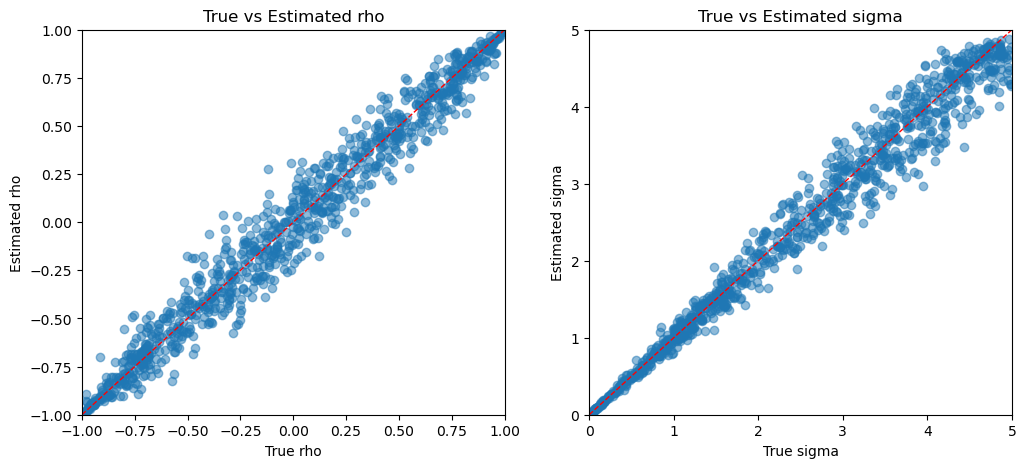

In [4]:
trials = 1000

real_thetas = np.zeros((trials, 2))
est_thetas = np.zeros((trials, 2))

real_thetas[:, 0] = np.random.uniform(-1, 1, size=trials)
real_thetas[:, 1] = np.random.uniform(0, A, size=trials)

for i in range(trials):
    x = np.zeros(T)

    rho, sigma = real_thetas[i]

    x_prev = np.random.normal(0, sigma ** 2 / (1 - rho ** 2))
    for j in range(T):
        x[j] = rho * x_prev + np.random.normal(0, sigma)
        x_prev = x[j]
    samples = gibbs(x, n_iter=1000)
    est_thetas[i, 0] = np.mean(samples[:, 0])
    est_thetas[i, 1] = np.mean(samples[:, 1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(real_thetas[:, 0], est_thetas[:, 0], alpha=0.5)
plt.plot([-1, 1], [-1, 1], color='r', linestyle='dashed', linewidth=1)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('True rho')
plt.ylabel('Estimated rho')
plt.title('True vs Estimated rho')
plt.subplot(1, 2, 2)
plt.scatter(real_thetas[:, 1], est_thetas[:, 1], alpha=0.5)
plt.plot([0, A], [0, A], color='r', linestyle='dashed', linewidth=1)
plt.xlim([0, A])
plt.ylim([0, A])
plt.xlabel('True sigma')
plt.ylabel('Estimated sigma')
plt.title('True vs Estimated sigma')

# CNN

In [5]:
import torch
from torch import nn
from torch.nn import functional as nnf

class MLP(nn.Module):
  '''
  A simple MLP with two hidden layers.
  '''
  def __init__(self, input_dim, output_dim, hidden_dim):
    super().__init__()
    self.nn = nn.Sequential(
      nn.Linear(input_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, output_dim)
    )
    
  def forward(self, x):
    return self.nn(x)
    

class PosteriorMeanEstimator(nn.Module):
    def __init__(
        self,
        summary_stats=32,
        summary_kernel_size=3,
        summary_channels=32,
        estimator_width=32,
        output_dim=1
    ):
        super().__init__()

        # Convnet summary layer
        padding = summary_kernel_size // 2
        self.summary = nn.Sequential(
            nn.Conv1d(1, summary_channels, summary_kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(summary_channels, summary_channels, summary_kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(summary_channels, summary_stats, summary_kernel_size, padding=padding),
        )
        # MLP estimator layer
        self.estimator = MLP(summary_stats, output_dim, hidden_dim=estimator_width)

    def forward(self, x):
        # We add an extra dimension to the input to set the number of input channels to one
        x_summary = self.summary(x.unsqueeze(-2))
        # We sum the summary statistics across all observations, then apply the estimator
        return self.estimator(x_summary.sum(-1))

neural_estimator = PosteriorMeanEstimator(output_dim=2)
x = torch.randn(4, 100)
output = neural_estimator(x)
print(output.shape)

torch.Size([4, 2])


Initial test loss: 3.0089


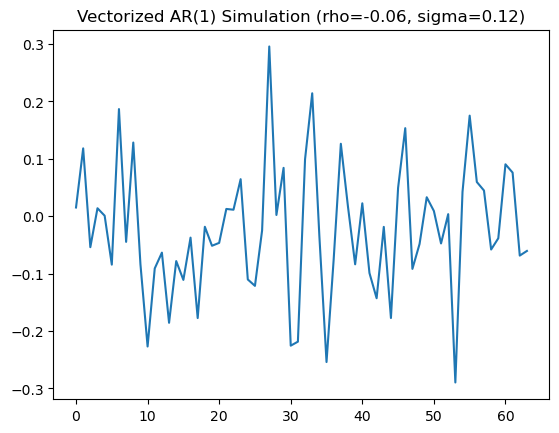

In [6]:
def sample_batch(batch_size, n, A=2.0, device='cpu'):
    rho = torch.empty(batch_size, device=device).uniform_(-1, 1)
    sigma = torch.empty(batch_size, device=device).uniform_(0, A)
    
    eps = torch.randn(batch_size, n, device=device) * sigma[:, None]
    
    x0 = torch.randn(batch_size, device=device) * sigma / torch.sqrt(1 - rho**2)
    
    x = torch.zeros(batch_size, n, device=device)
    x[:, 0] = rho * x0 + eps[:, 0]
    
    for t in range(1, n):
        x[:, t] = rho * x[:, t-1] + eps[:, t]
    
    return x, rho, sigma




# check that it works
x, rho, sigma = sample_batch(1024, 64)
plt.plot(x[0].cpu().numpy())
plt.title(f"Vectorized AR(1) Simulation (rho={rho[0].item():.2f}, sigma={sigma[0].item():.2f})")


loss_fn = torch.nn.MSELoss()
test_output = neural_estimator(x)
test_loss = loss_fn(test_output, torch.stack([rho, sigma], axis=1))
print(f"Initial test loss: {test_loss:.4f}")

Epoch 8/128, Train Loss: 0.5971, Test Loss: 0.1885
Epoch 16/128, Train Loss: 0.2037, Test Loss: 0.1834
Epoch 24/128, Train Loss: 0.1443, Test Loss: 0.1477
Epoch 32/128, Train Loss: 0.1241, Test Loss: 0.1209
Epoch 40/128, Train Loss: 0.1088, Test Loss: 0.1020
Epoch 48/128, Train Loss: 0.0943, Test Loss: 0.0913
Epoch 56/128, Train Loss: 0.1448, Test Loss: 0.1028
Epoch 64/128, Train Loss: 0.0915, Test Loss: 0.0794
Epoch 72/128, Train Loss: 0.1038, Test Loss: 0.0628
Epoch 80/128, Train Loss: 0.0672, Test Loss: 0.0559
Epoch 88/128, Train Loss: 0.0682, Test Loss: 0.0513
Epoch 96/128, Train Loss: 0.0635, Test Loss: 0.0480
Epoch 104/128, Train Loss: 0.0626, Test Loss: 0.0443
Epoch 112/128, Train Loss: 0.0895, Test Loss: 0.0436
Epoch 120/128, Train Loss: 0.0615, Test Loss: 0.0403
Epoch 128/128, Train Loss: 0.0717, Test Loss: 0.0386


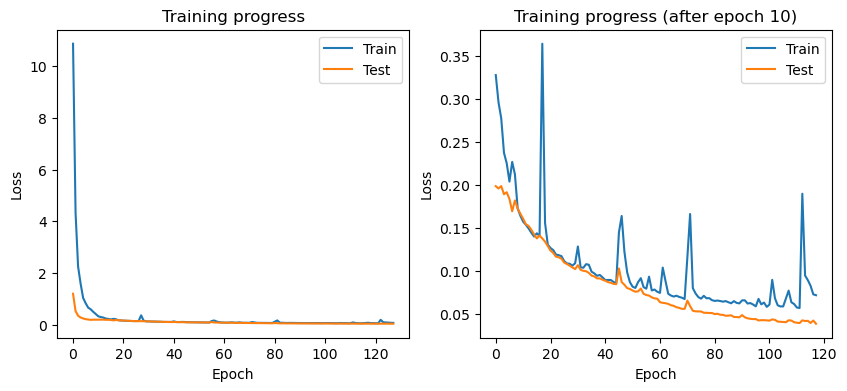

In [7]:

n_epochs = 128
n_batches_per_epoch = 128
training_batch_size = 128

optimizer = torch.optim.Adam(neural_estimator.parameters(), lr=0.00001)

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    for batch_idx in range(n_batches_per_epoch):
        x_batch, rho_batch, sigma_batch = sample_batch(training_batch_size, T, A=A)
        
        optimizer.zero_grad()
        lambda_pred = neural_estimator(x_batch)
        loss = loss_fn(lambda_pred, torch.stack([rho_batch, sigma_batch], axis=1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / n_batches_per_epoch
    train_losses.append(avg_epoch_loss)
    
    with torch.no_grad():
        lambda_pred_test = neural_estimator(x)
        test_loss = loss_fn(lambda_pred_test, torch.stack([rho, sigma], axis=1)).item()
        test_losses.append(test_loss)
    
    if (epoch + 1) % 8 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training progress')

plt.subplot(1, 2, 2)
plt.plot(train_losses[10:], label='Train')
plt.plot(test_losses[10:], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training progress (after epoch 10)')
plt.show()


# Comparison

In [8]:
x, rho, sigma = map(np.array, sample_batch(1000, T, A=A))

rho_gibbs = np.zeros(1000)
sigma_gibbs = np.zeros(1000)

for i in range(1000):
    samples = gibbs(x[i], n_iter=1000)
    rho_gibbs[i] = np.mean(samples[:, 0])
    sigma_gibbs[i] = np.mean(samples[:, 1])

In [9]:
rho_nn, sigma_nn = neural_estimator(torch.tensor(x, dtype=torch.float32)).detach().numpy().T

MSE rho (Gibbs): 0.0110
MSE sigma (Gibbs): 0.0597
MSE rho (NN): 0.0449
MSE sigma (NN): 0.1198


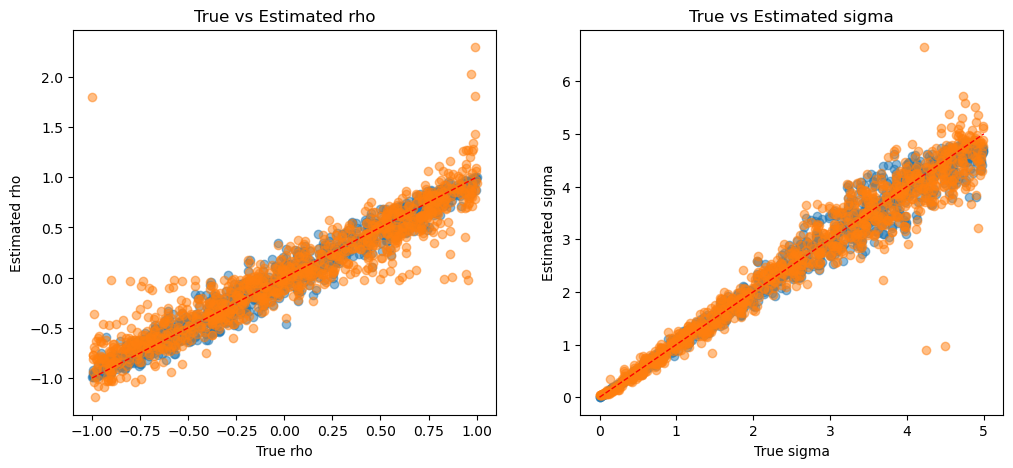

In [10]:
# plot true vs estimated posterior mean
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(rho, rho_gibbs, alpha=0.5)
plt.scatter(rho, rho_nn, alpha=0.5)
plt.plot([-1, 1], [-1, 1], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('True rho')
plt.ylabel('Estimated rho')
plt.title('True vs Estimated rho')
plt.subplot(1, 2, 2)
plt.scatter(sigma, sigma_gibbs, alpha=0.5)
plt.scatter(sigma, sigma_nn, alpha=0.5)
plt.plot([0, A], [0, A], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('True sigma')
plt.ylabel('Estimated sigma')
plt.title('True vs Estimated sigma')

print(f"MSE rho (Gibbs): {np.mean((rho - rho_gibbs)**2):.4f}")
print(f"MSE sigma (Gibbs): {np.mean((sigma - sigma_gibbs)**2):.4f}")
print(f"MSE rho (NN): {np.mean((rho - rho_nn)**2):.4f}")
print(f"MSE sigma (NN): {np.mean((sigma - sigma_nn)**2):.4f}")

# GRU Architecture

In [11]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
CUDA Version: 12.1


In [12]:
class GRUPosteriorEstimator(nn.Module):
    def __init__(
        self,
        input_dim=1,
        hidden_dim=64,
        num_layers=2,
        output_dim=2,
        mlp_hidden=64
    ):
        super().__init__()
        
        # GRU layer to process sequential data
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        # MLP to map from GRU to parameter estimates
        self.estimator = nn.Sequential(
            nn.Linear(hidden_dim, mlp_hidden),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(mlp_hidden, output_dim)
        )
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        
        gru_out, h_n = self.gru(x)
        
        last_hidden = h_n[-1] 
        
        return self.estimator(last_hidden)

# Create the GRU model
gru_estimator = GRUPosteriorEstimator(
    input_dim=1,
    hidden_dim=64,
    num_layers=2,
    output_dim=2,
    mlp_hidden=64
).to(device)

# Test the model
x_test = torch.randn(4, 64).to(device)
output_test = gru_estimator(x_test)
print(f"Output shape: {output_test.shape}")
print(f"Model parameters: {sum(p.numel() for p in gru_estimator.parameters())}")

Output shape: torch.Size([4, 2])
Model parameters: 46274


In [13]:
# Train the GRU model with GPU support
n_epochs = 128
n_batches_per_epoch = 128
training_batch_size = 128

optimizer = torch.optim.Adam(gru_estimator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses_gru = []
test_losses_gru = []

# Generate a fixed test set
x_test, rho_test, sigma_test = sample_batch(1024, T, A=A, device=device)

for epoch in range(n_epochs):
    gru_estimator.train()
    epoch_loss = 0.0
    
    for batch_idx in range(n_batches_per_epoch):
        x_batch, rho_batch, sigma_batch = sample_batch(training_batch_size, T, A=A, device=device)
        
        optimizer.zero_grad()
        lambda_pred = gru_estimator(x_batch)
        loss = loss_fn(lambda_pred, torch.stack([rho_batch, sigma_batch], axis=1))
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(gru_estimator.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / n_batches_per_epoch
    train_losses_gru.append(avg_epoch_loss)
    
    # Evaluation on test set
    gru_estimator.eval()
    with torch.no_grad():
        lambda_pred_test = gru_estimator(x_test)
        test_loss = loss_fn(lambda_pred_test, torch.stack([rho_test, sigma_test], axis=1)).item()
        test_losses_gru.append(test_loss)
    
    # Update learning rate
    scheduler.step(test_loss)
    
    if (epoch + 1) % 8 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 8/128, Train Loss: 0.0663, Test Loss: 0.0473, LR: 0.001000
Epoch 16/128, Train Loss: 0.0588, Test Loss: 0.0405, LR: 0.001000
Epoch 24/128, Train Loss: 0.0576, Test Loss: 0.0418, LR: 0.001000
Epoch 32/128, Train Loss: 0.0520, Test Loss: 0.0391, LR: 0.000500
Epoch 40/128, Train Loss: 0.0512, Test Loss: 0.0365, LR: 0.000500
Epoch 48/128, Train Loss: 0.0499, Test Loss: 0.0354, LR: 0.000500
Epoch 56/128, Train Loss: 0.0468, Test Loss: 0.0345, LR: 0.000250
Epoch 64/128, Train Loss: 0.0463, Test Loss: 0.0338, LR: 0.000250
Epoch 72/128, Train Loss: 0.0451, Test Loss: 0.0341, LR: 0.000125
Epoch 80/128, Train Loss: 0.0464, Test Loss: 0.0338, LR: 0.000125
Epoch 88/128, Train Loss: 0.0451, Test Loss: 0.0331, LR: 0.000063
Epoch 96/128, Train Loss: 0.0447, Test Loss: 0.0328, LR: 0.000063
Epoch 104/128, Train Loss: 0.0446, Test Loss: 0.0329, LR: 0.000016
Epoch 112/128, Train Loss: 0.0439, Test Loss: 0.0329, LR: 0.000008
Epoch 120/128, Train Loss: 0.0440, Test Loss: 0.0328, LR: 0.000004
Epoch 12

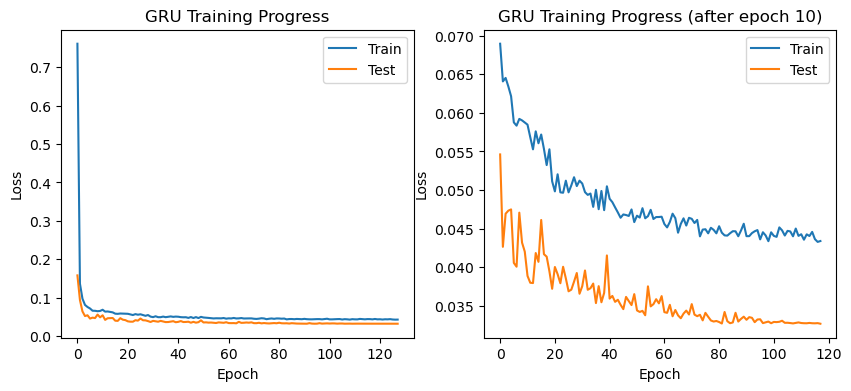

In [14]:
# Plot training progress for GRU
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gru, label='Train')
plt.plot(test_losses_gru, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Training Progress')

plt.subplot(1, 2, 2)
plt.plot(train_losses_gru[10:], label='Train')
plt.plot(test_losses_gru[10:], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Training Progress (after epoch 10)')
plt.show()

In [15]:
# Evaluate GRU model on test data and compare with Gibbs sampler
x_eval, rho_eval, sigma_eval = sample_batch(1000, T, A=A, device='cpu')
x_eval_np = x_eval.numpy()
rho_eval_np = rho_eval.numpy()
sigma_eval_np = sigma_eval.numpy()

# Gibbs sampler estimates (reuse from earlier or compute new ones)
rho_gibbs_eval = np.zeros(1000)
sigma_gibbs_eval = np.zeros(1000)

print("Running Gibbs sampler for comparison...")
for i in range(1000):
    samples = gibbs(x_eval_np[i], n_iter=1000)
    rho_gibbs_eval[i] = np.mean(samples[:, 0])
    sigma_gibbs_eval[i] = np.mean(samples[:, 1])

# GRU estimates
gru_estimator.eval()
with torch.no_grad():
    x_eval_gpu = x_eval.to(device)
    gru_pred = gru_estimator(x_eval_gpu).cpu().numpy()
    rho_gru = gru_pred[:, 0]
    sigma_gru = gru_pred[:, 1]

print("Evaluation complete!")

Running Gibbs sampler for comparison...
Evaluation complete!


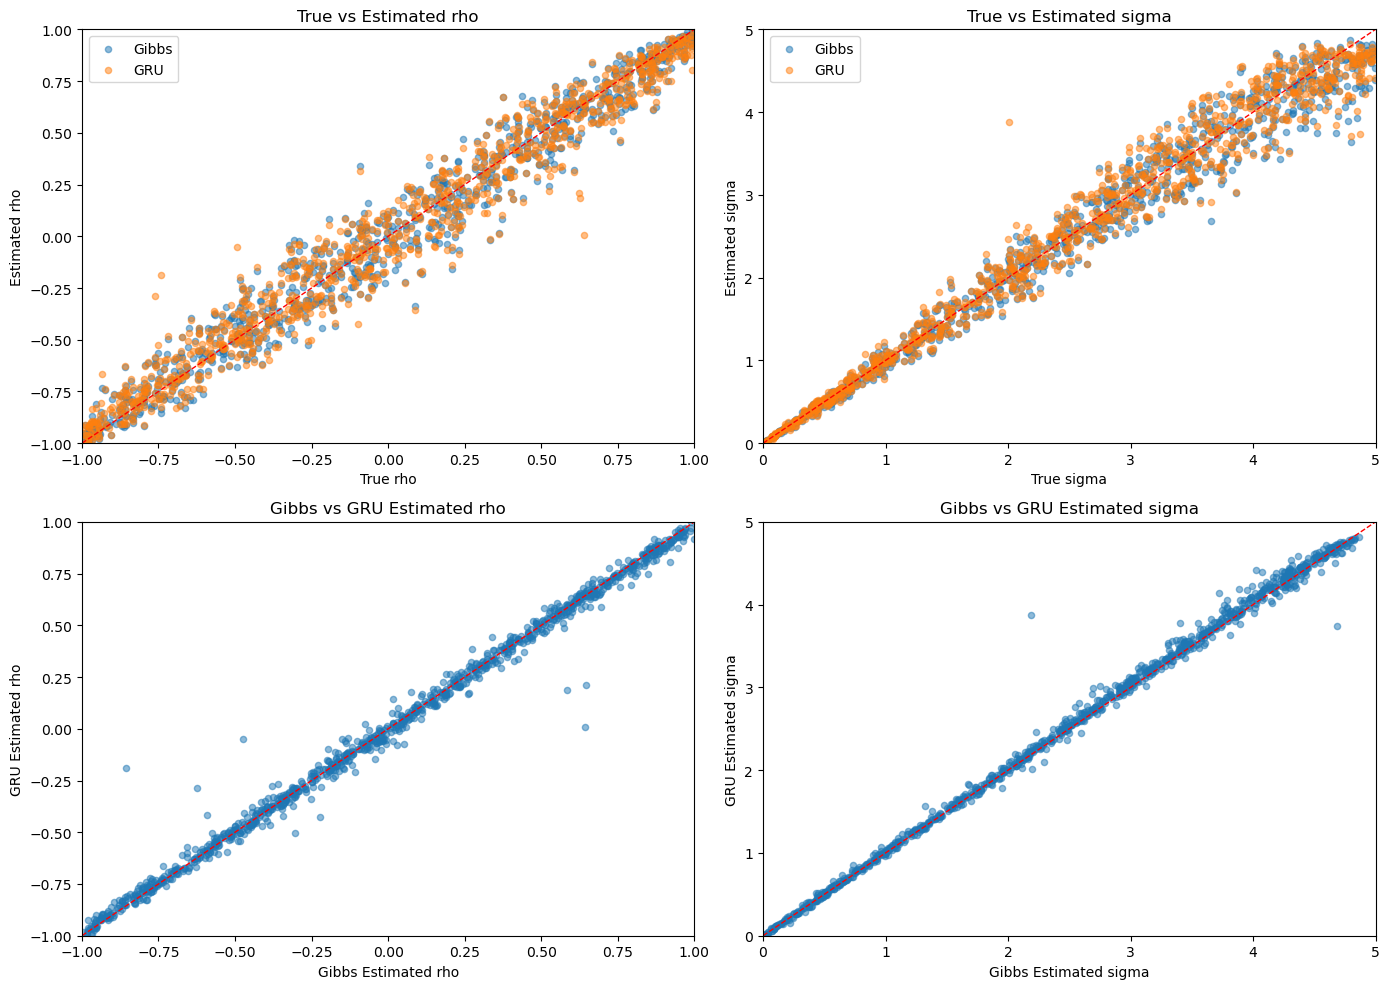

PERFORMANCE COMPARISON
MSE rho (Gibbs):  0.010941
MSE rho (GRU):    0.012932
Improvement:      -18.19%
------------------------------------------------------------
MSE sigma (Gibbs): 0.054935
MSE sigma (GRU):   0.058571
Improvement:       -6.62%


In [16]:
# Comprehensive comparison plot
plt.figure(figsize=(14, 10))

# Rho comparison
plt.subplot(2, 2, 1)
plt.scatter(rho_eval_np, rho_gibbs_eval, alpha=0.5, label='Gibbs', s=20)
plt.scatter(rho_eval_np, rho_gru, alpha=0.5, label='GRU', s=20)
plt.plot([-1, 1], [-1, 1], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('True rho')
plt.ylabel('Estimated rho')
plt.title('True vs Estimated rho')
plt.legend()
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Sigma comparison
plt.subplot(2, 2, 2)
plt.scatter(sigma_eval_np, sigma_gibbs_eval, alpha=0.5, label='Gibbs', s=20)
plt.scatter(sigma_eval_np, sigma_gru, alpha=0.5, label='GRU', s=20)
plt.plot([0, A], [0, A], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('True sigma')
plt.ylabel('Estimated sigma')
plt.title('True vs Estimated sigma')
plt.legend()
plt.xlim([0, A])
plt.ylim([0, A])

# gbbs vs gru for rho
plt.subplot(2, 2, 3)
plt.scatter(rho_gibbs_eval, rho_gru, alpha=0.5, s=20)
plt.plot([-1, 1], [-1, 1], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('Gibbs Estimated rho')
plt.ylabel('GRU Estimated rho')
plt.title('Gibbs vs GRU Estimated rho')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# gbbs vs gru for sigma
plt.subplot(2, 2, 4)
plt.scatter(sigma_gibbs_eval, sigma_gru, alpha=0.5, s=20)
plt.plot([0, A], [0, A], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('Gibbs Estimated sigma')
plt.ylabel('GRU Estimated sigma')
plt.title('Gibbs vs GRU Estimated sigma')
plt.xlim([0, A])
plt.ylim([0, A])

plt.tight_layout()
plt.show()

# Print MSE comparison
print("="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"MSE rho (Gibbs):  {np.mean((rho_eval_np - rho_gibbs_eval)**2):.6f}")
print(f"MSE rho (GRU):    {np.mean((rho_eval_np - rho_gru)**2):.6f}")
print(f"Improvement:      {(1 - np.mean((rho_eval_np - rho_gru)**2)/np.mean((rho_eval_np - rho_gibbs_eval)**2))*100:.2f}%")
print("-"*60)
print(f"MSE sigma (Gibbs): {np.mean((sigma_eval_np - sigma_gibbs_eval)**2):.6f}")
print(f"MSE sigma (GRU):   {np.mean((sigma_eval_np - sigma_gru)**2):.6f}")
print(f"Improvement:       {(1 - np.mean((sigma_eval_np - sigma_gru)**2)/np.mean((sigma_eval_np - sigma_gibbs_eval)**2))*100:.2f}%")
print("="*60)

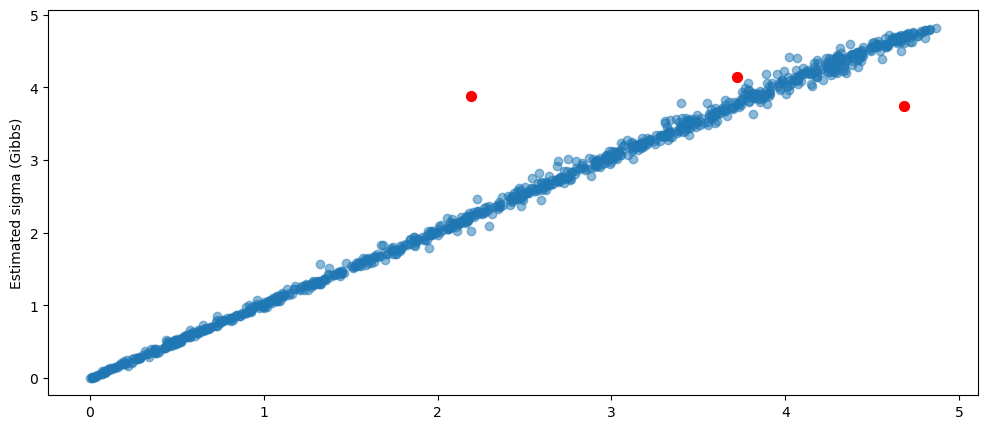

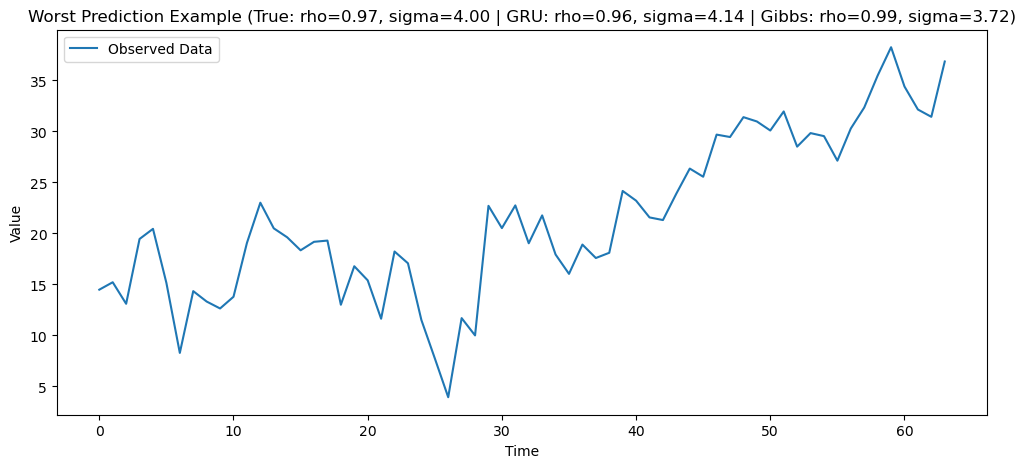

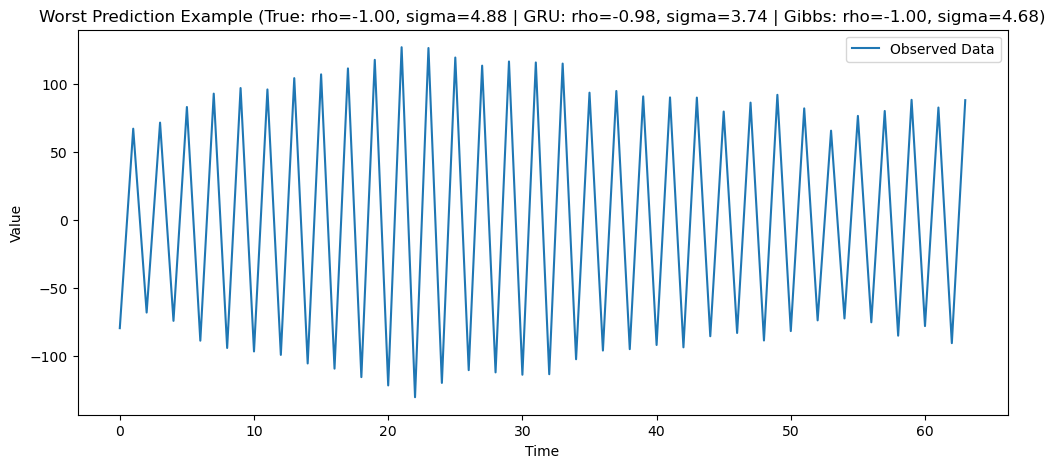

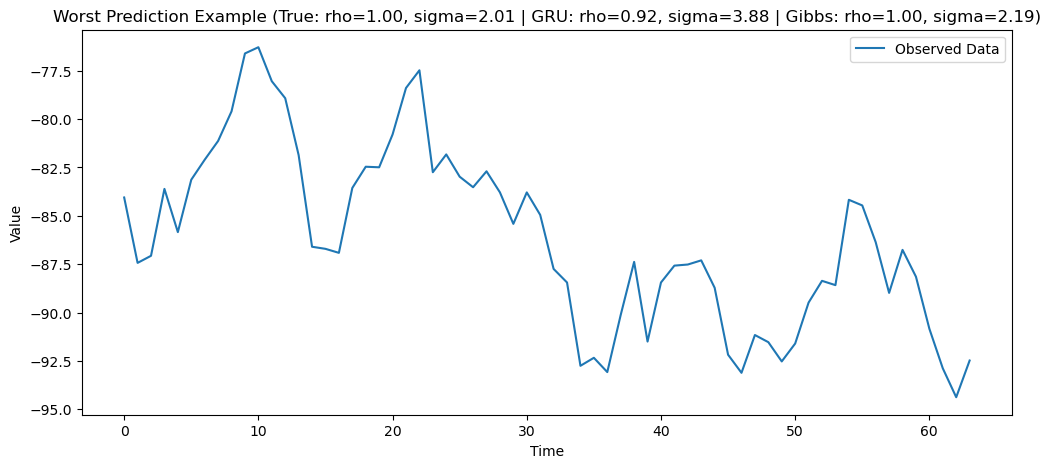

In [20]:
# now view the worse
worst_indices = np.argsort((sigma_gru - sigma_gibbs_eval)**2)[-3:]

# plot the worst cases in red
plt.figure(figsize=(12, 5))
plt.scatter(sigma_gibbs_eval, sigma_gru, alpha=0.5)
plt.scatter(sigma_gibbs_eval[worst_indices], sigma_gru[worst_indices], color='r', label='Worst Cases', s=50)
plt.ylabel('Estimated sigma (Gibbs)')
plt.show()

for idx in worst_indices:
    plt.figure(figsize=(12, 5))
    plt.plot(x_eval_np[idx], label='Observed Data')
    plt.title(f"Worst Prediction Example (True: rho={rho_eval_np[idx]:.2f}, sigma={sigma_eval_np[idx]:.2f} | GRU: rho={rho_gru[idx]:.2f}, sigma={sigma_gru[idx]:.2f} | Gibbs: rho={rho_gibbs_eval[idx]:.2f}, sigma={sigma_gibbs_eval[idx]:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

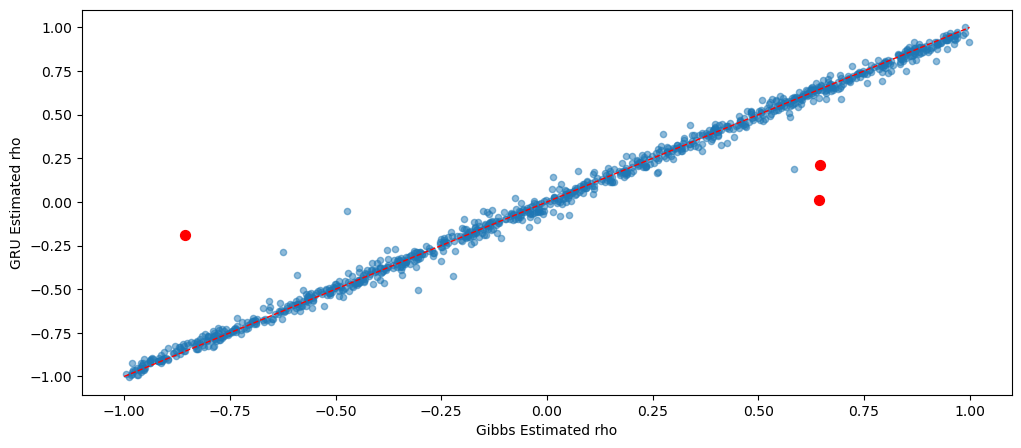

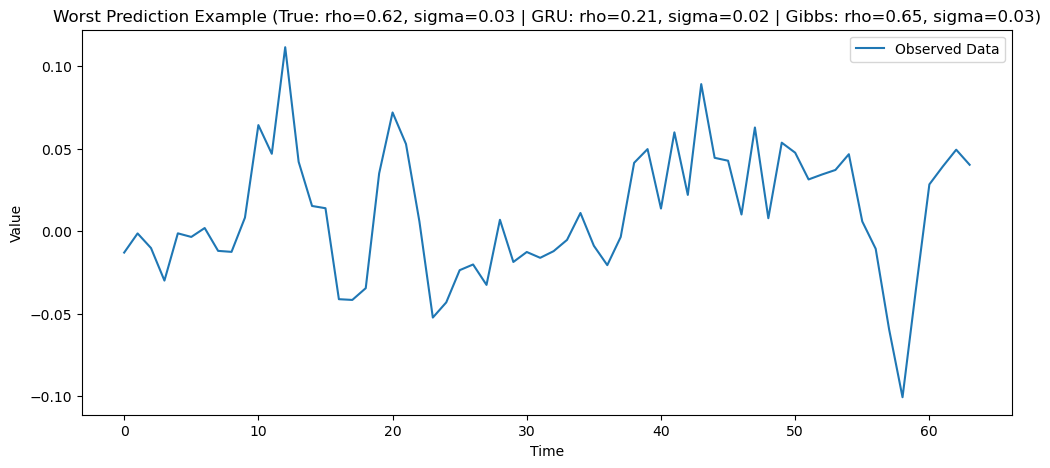

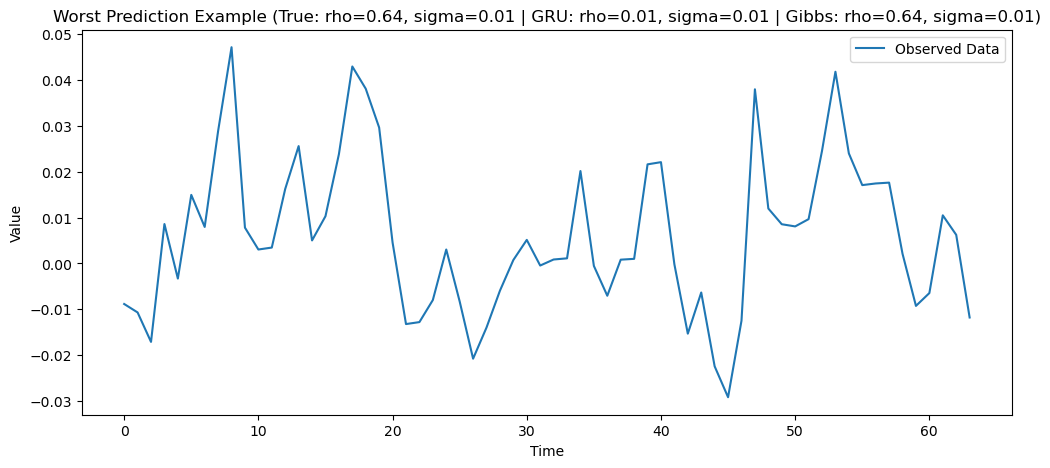

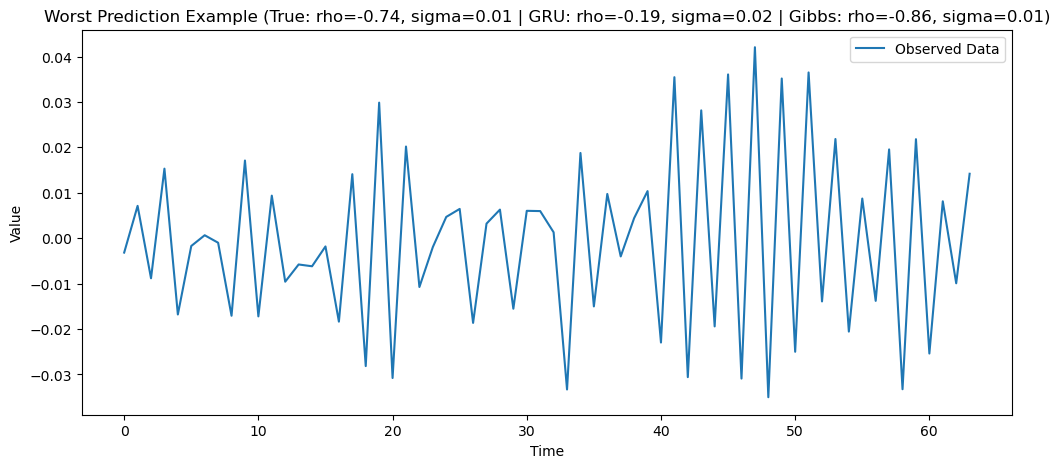

In [18]:
# lets view the worsst neural network predictions
worst_indices = np.argsort((rho_gru - rho_gibbs_eval)**2)[-3:]

# plot the worst predictions in red
plt.figure(figsize=(12, 5))
plt.scatter(rho_gibbs_eval, rho_gru, alpha=0.5, label='GRU', s=20)
plt.scatter(rho_gibbs_eval[worst_indices], rho_gru[worst_indices], color='r', label='Worst Predictions', s=50)
plt.plot([-1, 1], [-1, 1], color='r', linestyle='dashed', linewidth=1)
plt.xlabel('Gibbs Estimated rho')
plt.ylabel('GRU Estimated rho')
plt.show()


for idx in worst_indices:
    plt.figure(figsize=(12, 5))
    plt.plot(x_eval_np[idx], label='Observed Data')
    plt.title(f"Worst Prediction Example (True: rho={rho_eval_np[idx]:.2f}, sigma={sigma_eval_np[idx]:.2f} | GRU: rho={rho_gru[idx]:.2f}, sigma={sigma_gru[idx]:.2f} | Gibbs: rho={rho_gibbs_eval[idx]:.2f}, sigma={sigma_gibbs_eval[idx]:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()